# **Stellar Dataset**

### **Data Description:**
In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.


### **Data Content:**
The data consists of observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

### **Data Dictionary:**
- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- alpha = Right Ascension angle (at J2000 epoch)
- delta = Declination angle (at J2000 epoch)
- u = Ultraviolet filter in the photometric system
- g = Green filter in the photometric system
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- z = Infrared filter in the photometric system
- run_ID = Run Number used to identify the specific scan
- rereun_ID = Rerun Number to specify how the image was processed
- cam_col = Camera column to identify the scanline within the run
- field_ID = Field number to identify each field
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object) << your target
- redshift = redshift value based on the increase in wavelength
- plate = plate ID, identifies each plate in SDSS
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS - - - data was taken
- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

#### Import libraries and read files

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle

# Modeling process
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV


In [4]:
df = pd.read_csv("data/stellar.csv")
df.head()

,Unnamed: 0,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,41029,1.237649e+18,194.748212,-0.911226,25.77469,22.72579,20.84263,19.80384,19.29726,756,301,1,527,4.271919e+18,GALAXY,0.525770,3794,55241,926
1,42888,1.237661e+18,140.525977,35.614836,21.94718,21.31617,20.21319,19.45814,19.09832,3560,301,4,221,5.228710e+18,GALAXY,0.439029,4644,55922,111
2,82610,1.237658e+18,125.922894,38.044046,23.47268,21.34390,19.41544,18.67742,18.14655,2822,301,2,135,4.233595e+18,GALAXY,0.414493,3760,55268,770
3,89586,1.237664e+18,18.634831,0.468756,20.03793,18.13051,17.21534,16.80004,16.48915,4263,301,5,240,1.217236e+18,GALAXY,0.091736,1081,52531,503
4,14627,1.237666e+18,52.832458,1.215699,20.72916,20.34843,20.11169,19.75053,19.74247,4849,301,6,807,8.028670e+17,QSO,1.562706,713,52178,365


#### Data Exploring:

In [5]:
# check data structure
df.shape

(80000, 19)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   80000 non-null  int64  
 1   obj_ID       80000 non-null  float64
 2   alpha        80000 non-null  float64
 3   delta        80000 non-null  float64
 4   u            80000 non-null  float64
 5   g            80000 non-null  float64
 6   r            80000 non-null  float64
 7   i            80000 non-null  float64
 8   z            80000 non-null  float64
 9   run_ID       80000 non-null  int64  
 10  rerun_ID     80000 non-null  int64  
 11  cam_col      80000 non-null  int64  
 12  field_ID     80000 non-null  int64  
 13  spec_obj_ID  80000 non-null  float64
 14  class        80000 non-null  object 
 15  redshift     80000 non-null  float64
 16  plate        80000 non-null  int64  
 17  MJD          80000 non-null  int64  
 18  fiber_ID     80000 non-null  int64  
dtypes: f

In [93]:
# check for duplicates
df.duplicated().sum()

0

In [94]:
# check for missing values
df.isnull().sum().sum()

0

In [7]:
# drop unneccery columns
df.drop('Unnamed: 0', axis='columns', inplace=True)

In [8]:
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

In [97]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

#### Handling Multicollinearity

In [98]:
#check the corrolation
df.corr()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013633,-0.301188,0.014838,0.015268,0.152722,0.147506,0.013720,1.000000,NaN,-0.048166,0.032021,0.239657,0.065964,0.239657,0.262421,0.067931
alpha,-0.013633,1.000000,0.139960,-0.001654,-0.002469,-0.022075,-0.023910,-0.002993,-0.013635,NaN,0.020881,-0.165558,-0.000028,0.000072,-0.000029,0.022503,0.030957
delta,-0.301188,0.139960,1.000000,0.002714,0.003994,-0.007344,-0.004691,0.004123,-0.301190,NaN,0.034869,-0.174820,0.111966,0.032344,0.111966,0.106413,0.030435
u,0.014838,-0.001654,0.002714,1.000000,0.999450,0.049075,0.041356,0.998474,0.014837,NaN,0.003862,-0.009100,0.027260,0.013408,0.027260,0.028870,0.015317
g,0.015268,-0.002469,0.003994,0.999450,1.000000,0.056371,0.050771,0.999330,0.015268,NaN,0.003836,-0.009488,0.035699,0.021127,0.035698,0.036236,0.016428
r,0.152722,-0.022075,-0.007344,0.049075,0.056371,1.000000,0.963159,0.048657,0.152720,NaN,0.009218,-0.024619,0.653980,0.433485,0.653978,0.669826,0.223984
i,0.147506,-0.023910,-0.004691,0.041356,0.050771,0.963159,1.000000,0.050628,0.147504,NaN,0.007912,-0.024814,0.660873,0.493205,0.660871,0.671740,0.215427
z,0.013720,-0.002993,0.004123,0.998474,0.999330,0.048657,0.050628,1.000000,0.013719,NaN,0.003715,-0.009539,0.034232,0.027788,0.034232,0.033732,0.013909
run_ID,1.000000,-0.013635,-0.301190,0.014837,0.015268,0.152720,0.147504,0.013719,1.000000,NaN,-0.048267,0.032021,0.239656,0.065964,0.239656,0.262421,0.067918
rerun_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


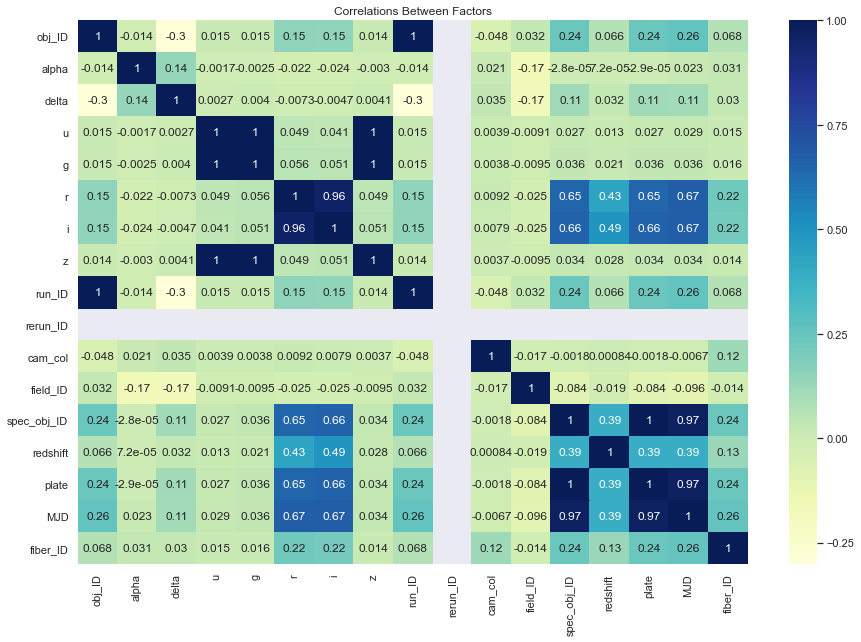

In [99]:
corr_matrix=df.corr()

# Create a Chart for the 6 Factors Correlations
sns.heatmap(corr_matrix, annot = True, cmap="YlGnBu")
plt.title(('Correlations Between Factors'))
sns.set(rc={'figure.figsize':(15,10)})

In [9]:
# Multicollinearity exists between features - ('u' and 'g'), ('g', 'r', 'i'), ('z', 'g', 'r', 'i'), ('spec_obj_ID' and 'plate')
#I will remove features - 'g', 'r', 'i', 'spec_obj_ID'.
df.drop(["g", "r", "i", "spec_obj_ID"], axis=1, inplace=True)

### Dimension reduction

In [10]:
#Drop the ID Columns and save them into ID dataframe
ID=df[['obj_ID','run_ID','rerun_ID','field_ID','fiber_ID']]
df.drop(['obj_ID','run_ID','rerun_ID','field_ID','fiber_ID'], axis=1, inplace=True)
ID

,obj_ID,run_ID,rerun_ID,field_ID,fiber_ID
0,1.237649e+18,756,301,527,926
1,1.237661e+18,3560,301,221,111
2,1.237658e+18,2822,301,135,770
3,1.237664e+18,4263,301,240,503
4,1.237666e+18,4849,301,807,365
...,...,...,...,...,...
79995,1.237654e+18,2074,301,211,335
79996,1.237663e+18,4072,301,60,1
79997,1.237665e+18,4508,301,141,139
79998,1.237665e+18,4571,301,31,517


In [11]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(ID)
ID_new = pd.DataFrame(data = principalComponents, columns = ['ID'])
ID_new


,ID
0,1.598441e+13
1,3.939732e+12
2,7.110498e+12
3,9.198324e+11
4,-1.597592e+12
...,...
79995,1.032313e+13
79996,1.740720e+12
79997,-1.324281e+11
79998,-4.024670e+11


In [12]:
df['ID']=ID_new
df

,alpha,delta,u,z,cam_col,class,redshift,plate,MJD,ID
0,194.748212,-0.911226,25.77469,19.29726,1,GALAXY,0.525770,3794,55241,1.598441e+13
1,140.525977,35.614836,21.94718,19.09832,4,GALAXY,0.439029,4644,55922,3.939732e+12
2,125.922894,38.044046,23.47268,18.14655,2,GALAXY,0.414493,3760,55268,7.110498e+12
3,18.634831,0.468756,20.03793,16.48915,5,GALAXY,0.091736,1081,52531,9.198324e+11
4,52.832458,1.215699,20.72916,19.74247,6,QSO,1.562706,713,52178,-1.597592e+12
...,...,...,...,...,...,...,...,...,...,...
79995,156.946589,58.686923,22.37756,18.34169,2,GALAXY,0.538937,7089,56661,1.032313e+13
79996,355.649333,44.738093,18.02005,16.35642,4,STAR,-0.001132,1886,53237,1.740720e+12
79997,132.990801,25.816729,25.69788,19.68414,5,GALAXY,0.765474,11122,58437,-1.324281e+11
79998,245.971013,19.218462,18.29851,17.81232,4,QSO,1.501470,2970,54589,-4.024670e+11


In [13]:
df.corr()

,alpha,delta,u,z,cam_col,redshift,plate,MJD,ID
alpha,1.000000,0.139960,-0.001654,-0.002993,0.020881,0.000072,-0.000029,0.022503,0.013633
delta,0.139960,1.000000,0.002714,0.004123,0.034869,0.032344,0.111966,0.106413,0.301188
u,-0.001654,0.002714,1.000000,0.998474,0.003862,0.013408,0.027260,0.028870,-0.014838
z,-0.002993,0.004123,0.998474,1.000000,0.003715,0.027788,0.034232,0.033732,-0.013720
cam_col,0.020881,0.034869,0.003862,0.003715,1.000000,0.000841,-0.001789,-0.006703,0.048166
redshift,0.000072,0.032344,0.013408,0.027788,0.000841,1.000000,0.388121,0.386759,-0.065964
plate,-0.000029,0.111966,0.027260,0.034232,-0.001789,0.388121,1.000000,0.970167,-0.239657
MJD,0.022503,0.106413,0.028870,0.033732,-0.006703,0.386759,0.970167,1.000000,-0.262421
ID,0.013633,0.301188,-0.014838,-0.013720,0.048166,-0.065964,-0.239657,-0.262421,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     80000 non-null  float64
 1   delta     80000 non-null  float64
 2   u         80000 non-null  float64
 3   z         80000 non-null  float64
 4   cam_col   80000 non-null  int64  
 5   class     80000 non-null  object 
 6   redshift  80000 non-null  float64
 7   plate     80000 non-null  int64  
 8   MJD       80000 non-null  int64  
 9   ID        80000 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 6.1+ MB


In [15]:
df['ID']= df['ID'].astype(str)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     80000 non-null  float64
 1   delta     80000 non-null  float64
 2   u         80000 non-null  float64
 3   z         80000 non-null  float64
 4   cam_col   80000 non-null  int64  
 5   class     80000 non-null  object 
 6   redshift  80000 non-null  float64
 7   plate     80000 non-null  int64  
 8   MJD       80000 non-null  int64  
 9   ID        80000 non-null  object 
dtypes: float64(5), int64(3), object(2)
memory usage: 6.1+ MB


### Encoding:

In [17]:
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]
df["class"].value_counts()

0    47556
1    17275
2    15169
Name: class, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


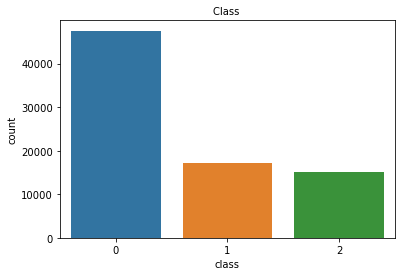

In [18]:
sns.countplot(df["class"])
plt.title("Class ",fontsize=10)
plt.show()

### Data splitting

#### Simple random sampling

In [108]:
# create train/test split
train, test = train_test_split(df, train_size=0.7, random_state=123)

# dimensions of training data
train.shape

(56000, 10)

In [109]:
df.columns

Index(['alpha', 'delta', 'u', 'z', 'cam_col', 'class', 'redshift', 'plate',
       'MJD', 'ID'],
      dtype='object')

In [110]:
## test 7:16 PM

#### Stratified sampling

In [111]:
y = df["class"]
train_strat, test_strat = train_test_split(df, train_size=0.3, random_state=123, 
                                           stratify=y)

In [112]:
# response distribution for raw data
df["class"].value_counts(normalize=True)

GALAXY    0.594450
STAR      0.215938
QSO       0.189612
Name: class, dtype: float64

In [113]:
train_strat["class"].value_counts(normalize=True)

GALAXY    0.594458
STAR      0.215917
QSO       0.189625
Name: class, dtype: float64

In [114]:
test_strat["class"].value_counts(normalize=True)

GALAXY    0.594446
STAR      0.215946
QSO       0.189607
Name: class, dtype: float64

#### Data imbalances

In [2]:
df.groupby('class').count().plot.bar()

NameError: name 'df' is not defined